In [20]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import random

from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, Dropout, Lambda, Subtract, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
from keras.regularizers import l2
from numpy.random import permutation
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(12345)

In [3]:
plt.rcParams["figure.figsize"] = (14,8)

In [4]:
num_classes = 10
epochs = 10

class_1 = 1
class_2 = 1
n_same_class_samples = 5000
n_diff_class_samples = 1500  # 3000
n_hybrid_class_samples = 1750

classes_to_train = [0,1,2,3,4,5]
classes_to_test = [6,7,8,9]

In [5]:
def generate_example_pairs(data, indices, class_1, class_2):
    class_1_indices = indices[class_1]
    class_2_indices = indices[class_2]

    image_0 = data[np.random.choice(class_1_indices)]
    image_1 = data[np.random.choice(class_2_indices)]
    # return [image_0, image_1]
    return [image_0.reshape(28,28,1), image_1.reshape(28,28,1)]


def generate_examples(data, indices, class_1, class_2):
    same_classes = [generate_example_pairs(data, indices, class_1, class_1) for _ in range(n_same_class_samples)]
    different_classes = [generate_example_pairs(data, indices,
                                                       np.random.choice(list(set(classes_to_train) - {class_1})),
                                                       np.random.choice(list(set(classes_to_train) - {class_2})))
                                for _ in range(n_diff_class_samples)]
    hybrid_classes = [generate_example_pairs(data, indices, class_1, np.random.choice(list(set(classes_to_train) - {class_2}))) for _ in range(n_hybrid_class_samples)] + \
                     [generate_example_pairs(data, indices, class_2, np.random.choice(list(set(classes_to_train) - {class_1}))) for _ in range(n_hybrid_class_samples)]

    images = same_classes + different_classes + hybrid_classes
    labels = [1] * n_same_class_samples + [0] * (n_diff_class_samples + n_hybrid_class_samples + n_hybrid_class_samples)
    return np.array(images), np.array(labels)

In [6]:
# https://keras.io/examples/mnist_siamese/
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [7]:
def create_conv_network(input_shape):
    convnet = Sequential()
    convnet.add(Conv2D(32,(3,3),padding="same",activation='relu',input_shape=input_shape))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(64,(7,7), padding="same", activation='relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(64,(4,4), padding = "same", activation='relu'))
    convnet.add(Flatten())
    convnet.add(Dense(128,activation="sigmoid"))
    return convnet

In [8]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    #   return K.mean(y_true * square_pred + (1-y_true) * margin_square)
    return K.mean(y_true * margin_square + (1 - y_true) * square_pred)

In [9]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

def recall_m(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, y_true.dtype)

    true_positives = (K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = (K.round(K.clip(y_true, 0, 1)))
    recall = K.mean(K.equal(true_positives, possible_positives))
    return recall

def precision_m(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, y_true.dtype)
    true_positives = (K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = (K.round(K.clip(y_pred, 0, 1)))
    precision = K.mean(K.equal(true_positives, predicted_positives))
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [10]:
def compute_accuracy(y_true, y_pred, threshold = 0.5):
    pred = y_pred.ravel() > threshold
    return np.mean(pred == y_true)

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = (28,28, 1)

n_classes = len(np.unique(y_train))

# Sample examples

In [12]:
sample_test_image_indices = np.random.choice(len(y_test), size = 20, replace = False)
sample_test_images = x_test[sample_test_image_indices]

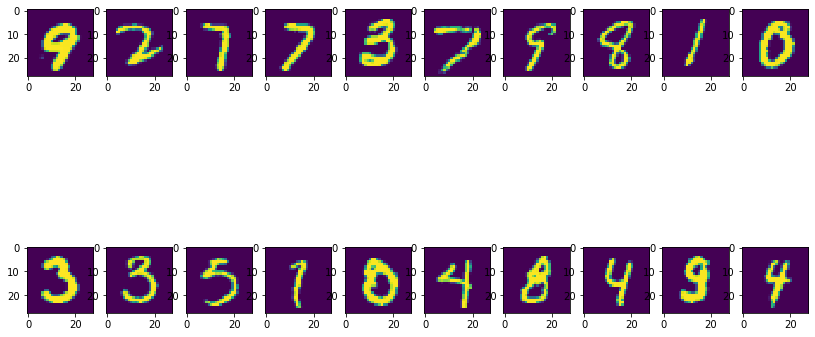

In [13]:
n_row = 2
n_col = 10
fig, ax = plt.subplots(n_row, n_col)
for row in range(n_row):
    for col in range(n_col):
        ax[row][col].imshow(sample_test_images[row*n_col + col])
plt.show()

# Class to Class SM

In [14]:
def C2C_SN(c1, c2):
    # create training+test positive and negative pairs
    training_digit_indices = {i:np.where(y_train == i)[0] for i in classes_to_train}
    training_pairs, training_label = generate_examples(x_train, training_digit_indices, c1, c2)

    # Use the classes that are being trained upon from the test data as the validation
    testing_digit_indices = {i:np.where(y_test == i)[0] for i in classes_to_train}
    testing_pairs, testing_label = generate_examples(x_test, testing_digit_indices, c1, c2)

    # network definition
    base_network = create_conv_network(input_shape)

    #base_network.summary()
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape) 

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # c2c lower model
    subtracted = Subtract()([processed_a, processed_b])
    x = Lambda(lambda val: abs(val))(subtracted)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(1, activation="sigmoid")(x)
    model = Model([input_a, input_b], out)

    rms = RMSprop()
    model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy, recall_m, precision_m, f1_m])
    model.fit([training_pairs[:,0], training_pairs[:,1]], training_label,
              batch_size=128,
              epochs=epochs,
              validation_data=([testing_pairs[:, 0], testing_pairs[:, 1]], testing_label))
    return model

In [15]:
models = {class_1: C2C_SN(class_1, class_1) for class_1 in classes_to_train}


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0556 - accuracy: 0.9239 - recall_m: 0.9422 - precision_m: 0.9816 - f1_m: 0.9563 - val_loss: 0.0076 - val_accuracy: 0.9917 - val_recall_m: 0.9967 - val_precision_m: 0.9950 - val_f1_m: 0.9958
Epoch 2/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0097 - accuracy: 0.9878 - recall_m: 0.9920 - precision_m: 0.9958 - f1_m: 0.9938 - val_loss: 0.0047 - val_accuracy: 0.9945 - val_recall_m: 0.9985 - val_precision_m: 0.9959 - val_f1_m: 0.9972
Epoch 3/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0057 - accuracy: 0.9926 - recall_m: 0.9963 - precision_m: 0.9962 - f1_m: 0.9963 - val_loss: 0.0042 - val_accuracy: 0.9955 - val_recall_m: 0.9994 - val_precision_m: 0.9960 - val_f1_m: 0.9977
Epoch 4/10
10000/10000 [=================

# Test Data

In [16]:
def calculate_scores(true_positive, false_positive, true_negative, false_negative):
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    f1 = 2 * precision * recall / (precision+recall)
    accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
    return precision, recall, f1, accuracy

In [18]:
# Pick one example from the classes that have been trained on
digit_indices = {i: np.random.choice(np.where(y_train == i)[0]) for i in classes_to_train}
precision, recall, f1, accuracy = [], [], [], []

for threshold in [0.9, 0.95, 0.975, 0.99, 0.995, 0.999]:
    # actually an outlier, predicted an outlier
    true_outliers = []
    # actually a seen label, predicted an outlier
    false_outliers = []
    # actually a seen label, predicted as seen
    true_inliers = []
    # actually outlier, predicted as seen
    false_inliers = []
    false_inliers_info = []
    for test_image, label in zip(x_test, y_test):
        predictions = {class_label: model.predict([x_train[digit_indices[class_label]].reshape(1,28,28,1), test_image.reshape(1,28,28, 1)]) for class_label, model in models.items()}
        predicted_class, confidence = sorted(predictions.items(), key = lambda el: el[1], reverse = True)[0]
        if label in classes_to_train:
        # Not outliers
            if confidence < threshold:
            # Not outliers, but predicted as outliers    
                false_outliers.append(test_image)
            else:
            # Not outliers, and predicted as non outliers
                true_inliers.append(test_image)
        else:
        # Outliers
            if confidence < threshold:
                # Outliers and predicted as outliers
                true_outliers.append(test_image)
            else:
                # Outliers and predicted as non outliers
                false_inliers.append(test_image)
                false_inliers_info.append({"True":label, "Predicted":predicted_class, "Confidence":confidence})
    p, r, f, a = calculate_scores(len(true_outliers), len(false_outliers), len(true_inliers), len(false_inliers))
    precision.append(p)
    recall.append(r)
    f1.append(f)
    accuracy.append(a)

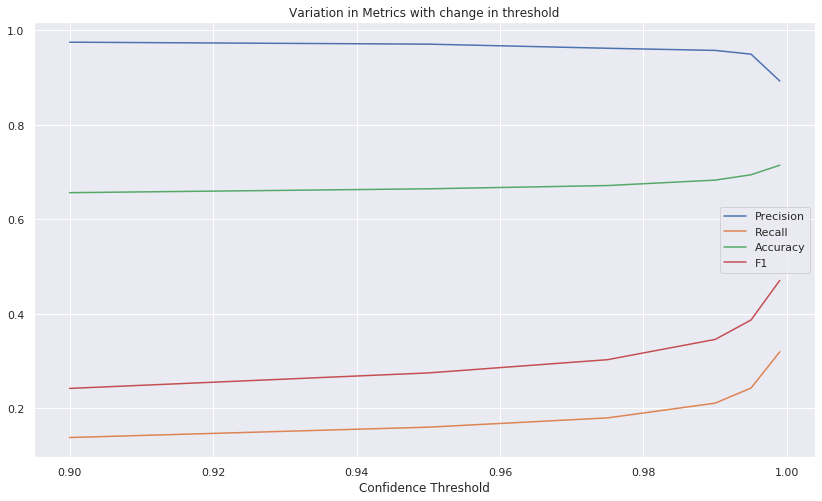

In [23]:
threshold_values = [0.9, 0.95, 0.975, 0.99, 0.995, 0.999]
plt.plot(threshold_values, precision, label="Precision")
plt.plot(threshold_values, recall, label="Recall")
plt.plot(threshold_values, accuracy, label="Accuracy")
plt.plot(threshold_values, f1, label = "F1")
plt.legend()
plt.xlabel("Confidence Threshold")
plt.title("Variation in Metrics with change in threshold")
plt.savefig("variation_in_metrics.png")
plt.show()

# Errors

In [28]:
sns.reset_orig()

[100  85  28  46  93 107  53  16  20  61]


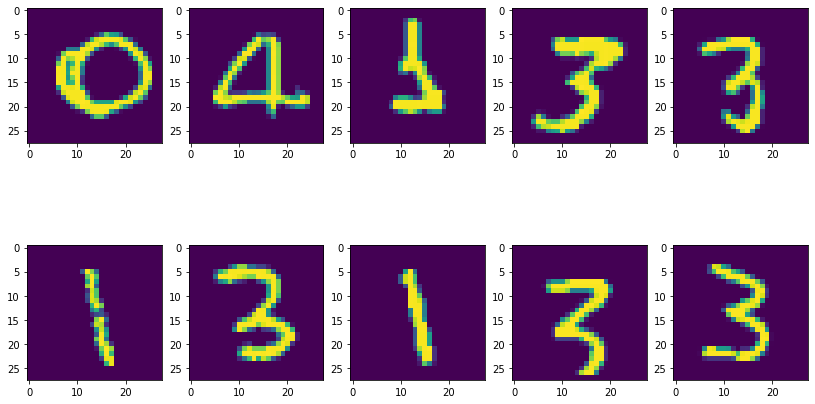

In [54]:
sample_false_outliers_indices = np.random.choice(len(false_outliers), 10, replace=False)
print(sample_false_outliers_indices)
sample_false_outliers = np.array(false_outliers)[sample_false_outliers_indices]

n_row = 2
n_col = 5
fig, ax = plt.subplots(n_row, n_col)
for row in range(n_row):
    for col in range(n_col):
        ax[row][col].imshow(sample_false_outliers[row*n_col + col])
plt.savefig("false_outliers.png")
plt.show()

[1663  141 2257 2303 2205 1375 1911 2556 2119 1289]


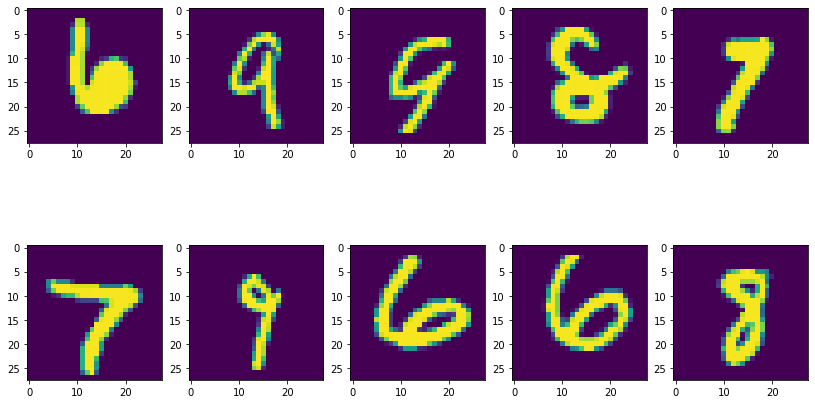

In [46]:
sample_false_inliers_indices = np.random.choice(len(false_inliers),10, replace=False)
print(sample_false_inliers_indices)
sample_false_inliers = np.array(false_inliers)[sample_false_inliers_indices]

sample_false_inliers_info = np.array(false_inliers_info)[sample_false_inliers_indices]

n_row = 2
n_col = 5
fig, ax = plt.subplots(n_row, n_col)
for row in range(n_row):
    for col in range(n_col):
        ax[row][col].imshow(sample_false_inliers[row*n_col + col])
plt.savefig("false_inliers.png")
plt.show()

In [44]:
sample_false_inliers_info

array([{'True': 7, 'Predicted': 3, 'Confidence': array([[0.9999995]], dtype=float32)},
       {'True': 9, 'Predicted': 4, 'Confidence': array([[0.99999523]], dtype=float32)},
       {'True': 6, 'Predicted': 0, 'Confidence': array([[0.99988735]], dtype=float32)},
       {'True': 7, 'Predicted': 4, 'Confidence': array([[0.99999964]], dtype=float32)},
       {'True': 8, 'Predicted': 3, 'Confidence': array([[0.9999589]], dtype=float32)},
       {'True': 9, 'Predicted': 4, 'Confidence': array([[0.99999964]], dtype=float32)},
       {'True': 7, 'Predicted': 2, 'Confidence': array([[0.99994326]], dtype=float32)},
       {'True': 9, 'Predicted': 4, 'Confidence': array([[0.9999999]], dtype=float32)},
       {'True': 7, 'Predicted': 3, 'Confidence': array([[0.9999949]], dtype=float32)},
       {'True': 9, 'Predicted': 3, 'Confidence': array([[0.9998995]], dtype=float32)}],
      dtype=object)

# F1 score calculation

In [21]:
metrics = {0.5: (296, 14, 6017, 3673),
0.6: (322, 17, 6014, 3647),
0.7: (342, 19, 6012, 3627),
0.8: (374, 20, 6011, 3595),
0.9: (434, 24, 6007, 3535),
0.95: (511, 31, 6000, 3458),
0.99: (722, 123, 5908, 3247),
0.995: (919, 297, 5734, 3050),
0.999: (1947, 1424, 4607, 2022),
0.9999: (3432, 3643, 2388, 537)}

In [23]:
{el:calculate_scores(*values) for el, values in metrics.items()}

{0.5: (0.9548387096774194, 0.0745779793398841, 0.13835008179481187, 0.6313),
 0.6: (0.9498525073746312, 0.08112874779541446, 0.14948932219127203, 0.6336),
 0.7: (0.9473684210526315, 0.08616780045351474, 0.1579676674364896, 0.6354),
 0.8: (0.949238578680203, 0.09423028470647518, 0.17144166857666743, 0.6385),
 0.9: (0.9475982532751092, 0.10934744268077601, 0.1960695730743167, 0.6441),
 0.95: (0.9428044280442804, 0.12874779541446207, 0.22655730436710264, 0.6511),
 0.99: (0.8544378698224852, 0.18190980095742001, 0.29995845450768593, 0.663),
 0.995: (0.7557565789473685, 0.23154446963970773, 0.3544840887174542, 0.6653),
 0.999: (0.5775734203500444, 0.490551776266062, 0.530517711171662, 0.6554),
 0.9999: (0.48508833922261485, 0.8647014361300076, 0.6215139442231076, 0.582)}

In [76]:
a = {0.99:  (1645, 59, 5972, 2324),
0.995: (1772, 111, 5920, 2197),
0.999: (2150, 673, 5358, 1819)}

In [77]:
{el:calculate_scores(*values) for el, values in a.items()}

{0.99: (0.9653755868544601, 0.4144620811287478, 0.5799400669839591, 0.7617),
 0.995: (0.9410515135422198, 0.4464600655076846, 0.6056049213943951, 0.7692),
 0.999: (0.7616011335458732, 0.5416981607457798, 0.6330977620730271, 0.7508)}

In [101]:
calculate_scores(1750, 397, 5634, 2219)

(0.8150908244061481, 0.4409171075837742, 0.5722694571615434, 0.7384)

In [118]:
calculate_scores(1538, 88, 5943, 2431)

(0.9458794587945879, 0.3875031494079113, 0.5497765862377122, 0.7481)